# 黃金交叉期貨交易策略（MTX）

## 前言
---
移動平均線（Moving Average, MA）的思想源於 20 世紀初的 **道氏理論（Dow Theory）**。道氏理論強調市場具有趨勢性，且趨勢可透過價格本身來觀察，但早期價格資料波動劇烈，缺乏平滑工具。分析者因此開始利用一段期間的平均價格來減少隨機雜訊，這便是移動平均線的濫觴。  

隨著統計學與電腦運算的進步，移動平均線逐漸成為量化交易最基礎的技術指標之一。從簡單移動平均（SMA）、指數移動平均（EMA），到更複雜的變體如雙指數移動平均（DEMA）、Hull MA 等，均線的改良目的皆在於解決傳統均線的「延遲性」問題，使其更快速或更平滑地反映價格趨勢。  

在應用層面，均線策略廣泛存在於不同市場：  
1. **單均線突破**：價格突破長期均線（如 200 日）來判斷多空。  
2. **雙均線交叉**：短期均線與長期均線交叉作為進出場訊號。  
3. **多均線排列**：觀察均線是否呈現多頭或空頭排列，以確認趨勢強弱。  
4. **均線與風控結合**：均線訊號搭配停損、波動率或濾網，增強穩健性。  

其中，最具代表性的莫過於「**黃金交叉（Golden Cross）**」與「**死亡交叉（Death Cross）**」。當短期均線上穿長期均線，往往被視為多頭趨勢啟動；反之則意味空頭來臨。然而，單純依賴交叉訊號在震盪市容易產生假突破，因此實務上常搭配多層停損、風控濾網與期貨換月處理，以提高策略的可行性與穩健性。

本策略即在黃金交叉框架下，結合移動停損與濾網動態管控風險，並應用連續合約處理期貨換月，使回測與實盤保持一致性。  

## 投資標的與回測期間
---
- **標的**：小台指期（**MTX** 連續合約）  
- **資料頻率**：日線（收盤價）  
- **基準（Benchmark）**：**台灣加權報酬指數** (IR0001)  
- **回測區間**：**2020-01-02 ～ 2025-09-26**  
- **合約轉倉**：使用連續合約（calendar roll, adjustment=add），確保到期換月的績效連續性  

## 核心邏輯
---
### 1. 指標系統 (Indicator System)
- 使用 **MA3 / MA10** 辨識趨勢。  
- **黃金交叉**為買進觸發；**死亡交叉**為出場訊號。  
- 為降低雜訊，黃金交叉在程式端加入 **1.0001 緩衝條件**（短均需明顯高於長均）。  

### 2. 濾網機制（核心風險管理）
- **開啟條件**：當 **benchmark 近 2 日跌幅 ≤ −5%** 時，濾網 **ON**。  
- **關閉條件**（依目前程式實作）：  
  - **市場反彈關閉**：**benchmark 近 2 日漲幅 ≥ +5%** → 濾網 **OFF**。  
  - **自動關閉**：濾網開啟 **200 天** 後自動 **OFF**。  
- **濾網 ON 時處置**：只要有持倉，**無條件強制平倉**；且（與停損相同）**需等待 5 個交易日** 才可再度進場。  

### 3. 進場邏輯（僅在濾網 OFF 時執行）
- **黃金交叉買進**：  
  - 條件：`(MA3[-2] < MA10[-2]) and (MA3[-1] > MA10[-1] * 1.0001)`  
  - 動作：**全倉買進**，**槓桿 1.8 倍**  
  - 限制：若前次為停損或濾網強平，需 **等待 5 日** 才能再次進場  

### 4. 出場與風險管理
- **濾網觸發（ON）**：有倉位即 **強制平倉**。  
- **濾網未觸發（OFF）時**：  
  1. **停損平倉**：  
     - 1 日：`return_1d < −5%`  
     - 5 日：`return_5d < −10%`  
     - 10 日：`return_10d < −15%`  
  2. **死亡交叉**：`(MA3[-2] > MA10[-2]) and (MA3[-1] < MA10[-1])` → 平倉  
  3. **時間停損**：**持有超過 200 天** → 平倉  

### 5. 合約轉倉 (Contract Rolling)
- 使用 **連續合約（MTX）** 自動處理換月，避免因到期造成的價格斷層與績效失真。  

## 交易流程圖
---
```plaintext
每日收盤 → 更新濾網狀態
   ├─ 濾網關閉？ ──► 否（濾網 ON）
   │                       ├─ 有持倉 → 強制平倉（並啟動 5 日等待）
   │                       └─ 無持倉 → 不進場
   │
   └─ 是（濾網 OFF）
        ├─ 有持倉
        │     ├─ 停損（1D/5D/10D） → 平倉（並啟動 5 日等待）
        │     ├─ 死亡交叉 → 平倉
        │     ├─ 持有超過 200 天 → 平倉
        │     └─ 其餘 → 繼續持有
        │
        └─ 無持倉
              ├─ （若處於等待期）→ 不進場，等待期 −1
              ├─ 黃金交叉（含 1.0001 緩衝）→ 全倉買進（槓桿 1.8x）
              └─ 否 → 不進場
```

## 策略特色
---
1. **動態風險管理**：濾網在市場急跌時強化資本保護（ON 強平 + 5 日冷卻）。  
2. **避免雜訊交易**：黃金交叉加入 MA10[-1] * 1.0001` 設定，降低假突破。  
3. **多層出場保護**：三段式停損 + 技術指標 + 時間停損。  
4. **嚴格風控執行**：濾網觸發即時清倉，避免承擔下行尾部風險。  
5. **轉倉一致性**：連續合約確保回測與實盤的一致與可解釋性。  


In [1]:
#%% Setup

ticker1 = 'IR0001 IX0001'
ticker2 = 'MTX MSCI NYF'

# 環境變數
import os
import sys
# import time  # 未使用
import yaml

''' ------------------- 不使用 config.yaml 管理 API KEY 的使用者可以忽略以下程式碼 -------------------'''
notebook_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()
yaml_path = os.path.join(notebook_dir, '..', 'config.yaml')
yaml_path = os.path.abspath(os.path.join(notebook_dir, '..', 'config.yaml'))
with open(yaml_path, 'r') as tejapi_settings: config = yaml.safe_load(tejapi_settings)
''' ------------------- 不使用 config.yaml 管理 API KEY 的使用者可以忽略以上程式碼 -------------------'''

# --------------------------------------------------------------------------------------------------
os.environ['TEJAPI_BASE']   = config['TEJAPI_BASE'] # = "https://api.tej.com.tw"
os.environ['TEJAPI_KEY']    = config['TEJAPI_KEY']  # = "YOUR_API_KEY"
# --------------------------------------------------------------------------------------------------
os.environ['ticker']        = ticker1
os.environ['future']        = ticker2
os.environ['mdate']         = '20180101 20251002'
!zipline ingest -b tquant_future

# 數據分析套件
import warnings
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt


from logbook import Logger, StderrHandler, INFO


# tquant 相關套件
# import tejapi  
# import TejToolAPI  
import zipline
import pyfolio as pf

from zipline.utils.calendar_utils import get_calendar
from zipline.utils.events import date_rules, time_rules
from zipline.finance.commission import (
    PerContract
)
from zipline.finance.slippage import (
    FixedSlippage
)
from zipline import run_algorithm

from zipline.api import (
    record, 
    schedule_function,
    set_slippage, 
    set_commission, 
    order_value,
    set_benchmark, 
    symbol, 
    get_datetime,
    date_rules, 
    time_rules, 
    continuous_future
)
from pyfolio.utils import extract_rets_pos_txn_from_zipline

# logbook 設定
warnings.filterwarnings('ignore')
print(sys.executable)
print(sys.version)
print(sys.prefix)

log_handler = StderrHandler(
    format_string = (
        '[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
        '{record.level_name}: {record.func_name}: {record.message}'
    ),
    level=INFO
)
log_handler.push_application()
log = Logger('Algorithm')

[2025-10-15 03:26:33.619466] INFO: zipline.data.bundles.core: Ingesting tquant_future.
[2025-10-15 03:26:40.481559] INFO: zipline.data.bundles.core: Ingest tquant_future successfully.


Merging daily equity files:
c:\Users\Gary\anaconda3\envs\py311-tq2\python.exe
3.11.13 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:03:15) [MSC v.1929 64 bit (AMD64)]
c:\Users\Gary\anaconda3\envs\py311-tq2


最大槓桿：1.85 倍
[Trading log---------------]: ----------------------------- | signal ----- |action|Original posi| Note


[2025-10-15 03:26:50.482125]: INFO: ma_strategy: 2020-01-13 | Golden Cross | buy  | position: 0 | Amount: 1800000.0
[2025-10-15 03:26:50.548702]: INFO: ma_strategy: 2020-01-30 | Filter ON    | Benchmark 2d return: -5.53%
[2025-10-15 03:26:50.887757]: INFO: ma_strategy: 2020-03-24 | Filter OFF   | Benchmark 3d return: 6.96%
[2025-10-15 03:26:50.908865]: INFO: ma_strategy: 2020-03-26 | Golden Cross | buy  | position: 0 | Amount: 1778256.0
[2025-10-15 03:26:51.094413]: INFO: ma_strategy: 2020-04-27 | Golden Cross | buy  | position: 0 | Amount: 2012940.0
[2025-10-15 03:26:51.244013]: INFO: ma_strategy: 2020-05-18 | Death Cross  | sell | position: 3 | Hold Days: 14
[2025-10-15 03:26:51.279363]: INFO: ma_strategy: 2020-05-21 | Golden Cross | buy  | position: 0 | Amount: 2095344.0
[2025-10-15 03:26:51.445875]: INFO: ma_strategy: 2020-06-15 | Death Cross  | sell | position: 3 | Hold Days: 17
[2025-10-15 03:26:51.485869]: INFO: ma_strategy: 2020-06-18 | Golden Cross | buy  | position: 0 | Amoun

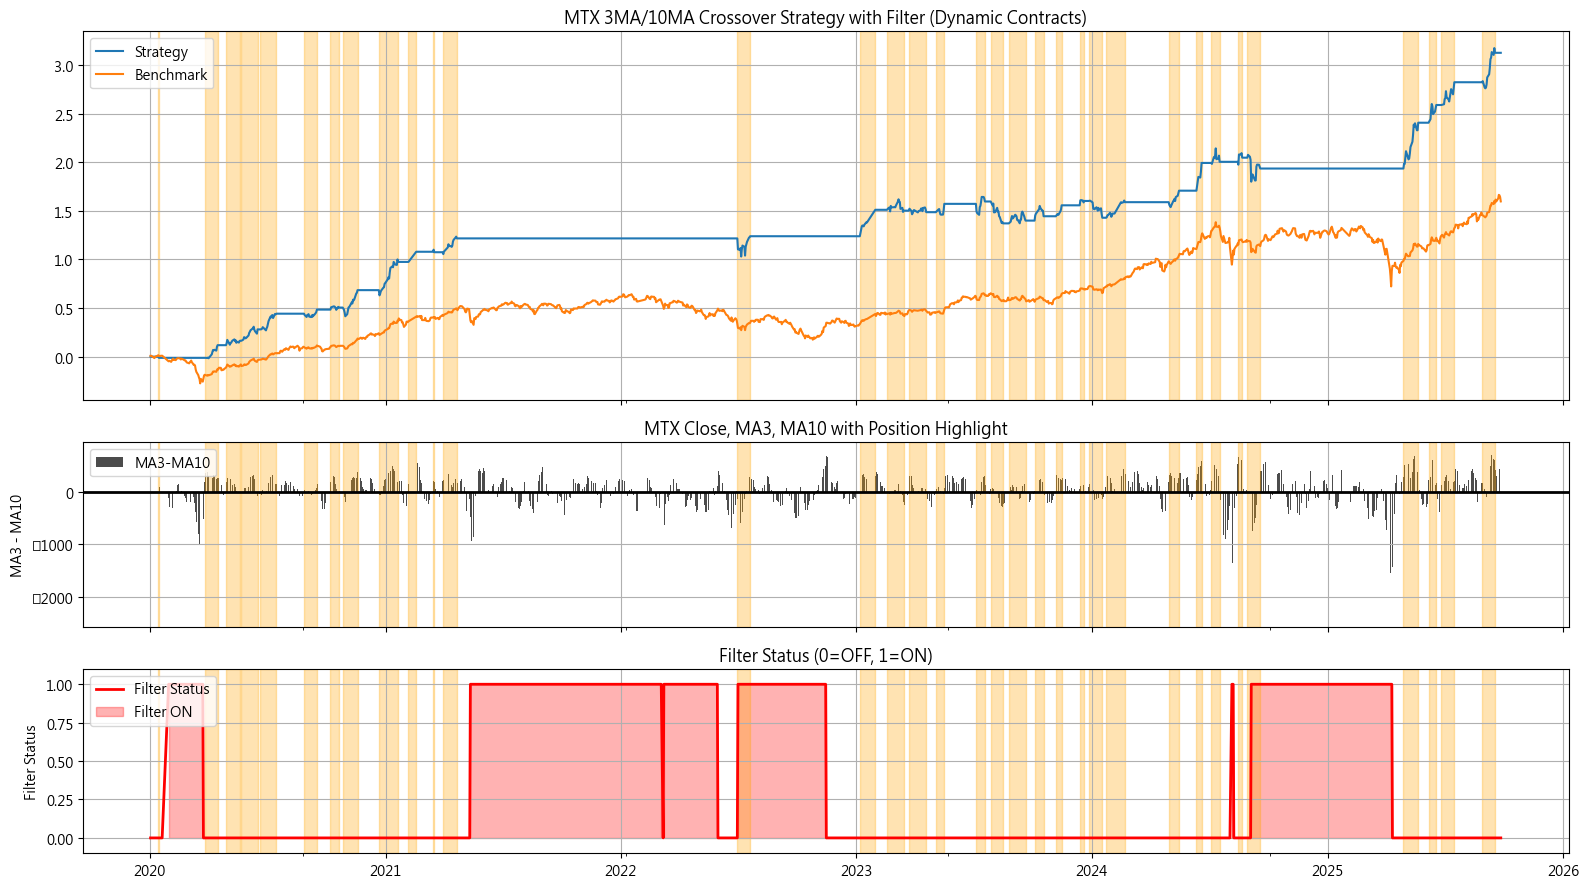

benchmark_rets: 2020-01-02 00:00:00+00:00    0.008614
2020-01-03 00:00:00+00:00    0.000823
2020-01-06 00:00:00+00:00   -0.012970
2020-01-07 00:00:00+00:00   -0.006110
2020-01-08 00:00:00+00:00   -0.005322
Name: benchmark_return, dtype: float64


Start date,2020-01-02
End date,2025-09-26
Total months,66
,Backtest
Annual return,29.162%
Cumulative returns,312.722%
Annual volatility,13.704%
Sharpe ratio,1.94
Calmar ratio,2.67
Stability,0.81
Max drawdown,-10.902%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,10.90,2024-07-11,2024-09-04,2025-05-09,198
1,10.30,2023-07-14,2023-08-25,2024-05-13,201
2,9.16,2021-04-20,2022-07-06,2022-07-20,309
3,6.69,2020-10-12,2020-10-30,2020-11-06,20
4,6.09,2023-03-07,2023-07-10,2023-07-14,88


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the foll

Top 10 long positions of all time,max
sid,
MTX202009,64.14%
MTX202007,64.14%
MTX202401,63.85%
MTX202011,63.68%
MTX202309,63.38%
MTX202308,63.30%
MTX202101,63.26%
MTX202010,63.23%
MTX202207,63.08%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
MTX202009,64.14%
MTX202007,64.14%
MTX202401,63.85%
MTX202011,63.68%
MTX202309,63.38%
MTX202308,63.30%
MTX202101,63.26%
MTX202010,63.23%
MTX202207,63.08%


,Strategy,Benchmark
Annual return,0.2916,0.1881
Cumulative returns,3.1272,1.5977
Annual volatility,0.1370,0.1978
Sharpe ratio,1.9365,0.9707
Calmar ratio,2.6749,0.6587
Stability,0.8124,0.8224
Max drawdown,-0.1090,-0.2855
Omega ratio,1.8757,1.1919
Sortino ratio,3.2789,1.3591
Skew,0.5411,-0.5698


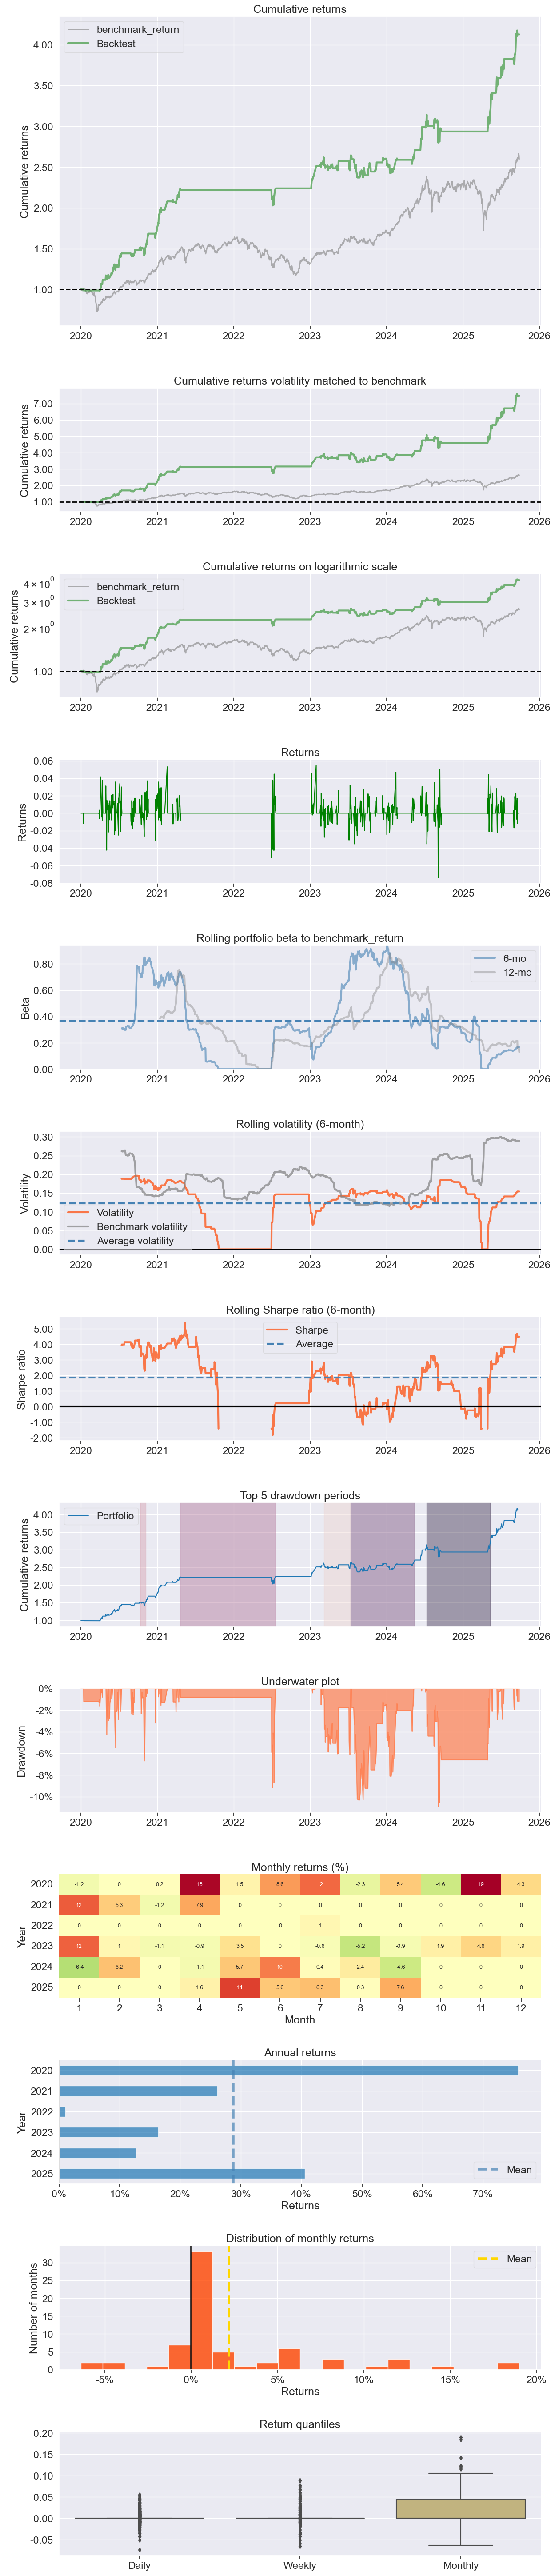

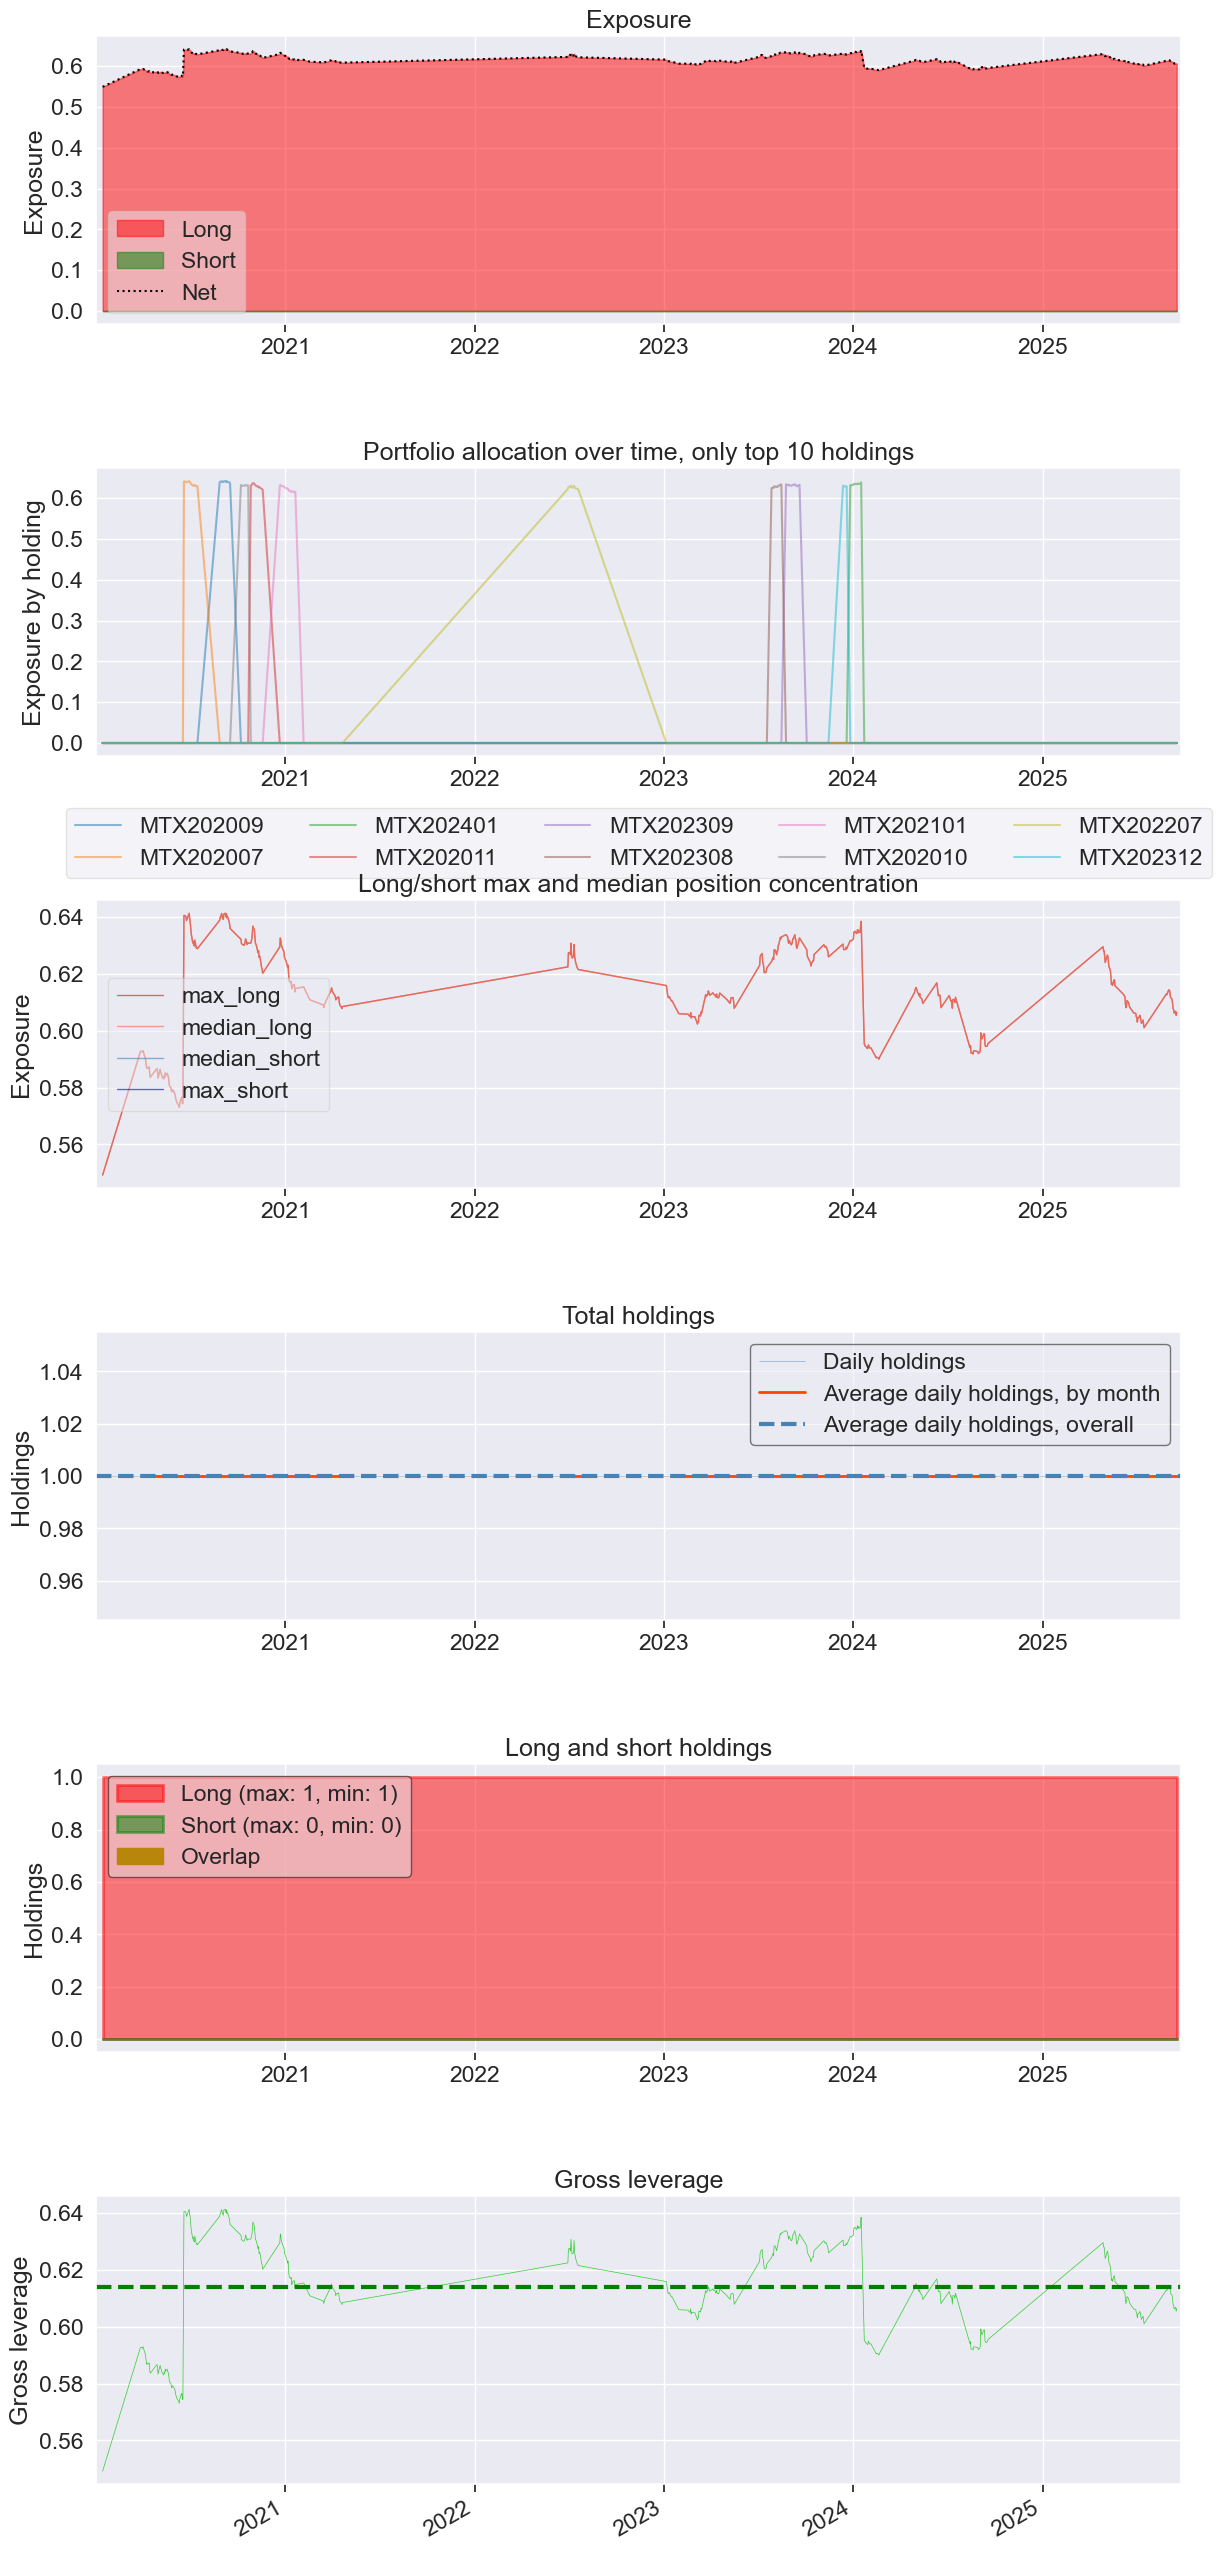

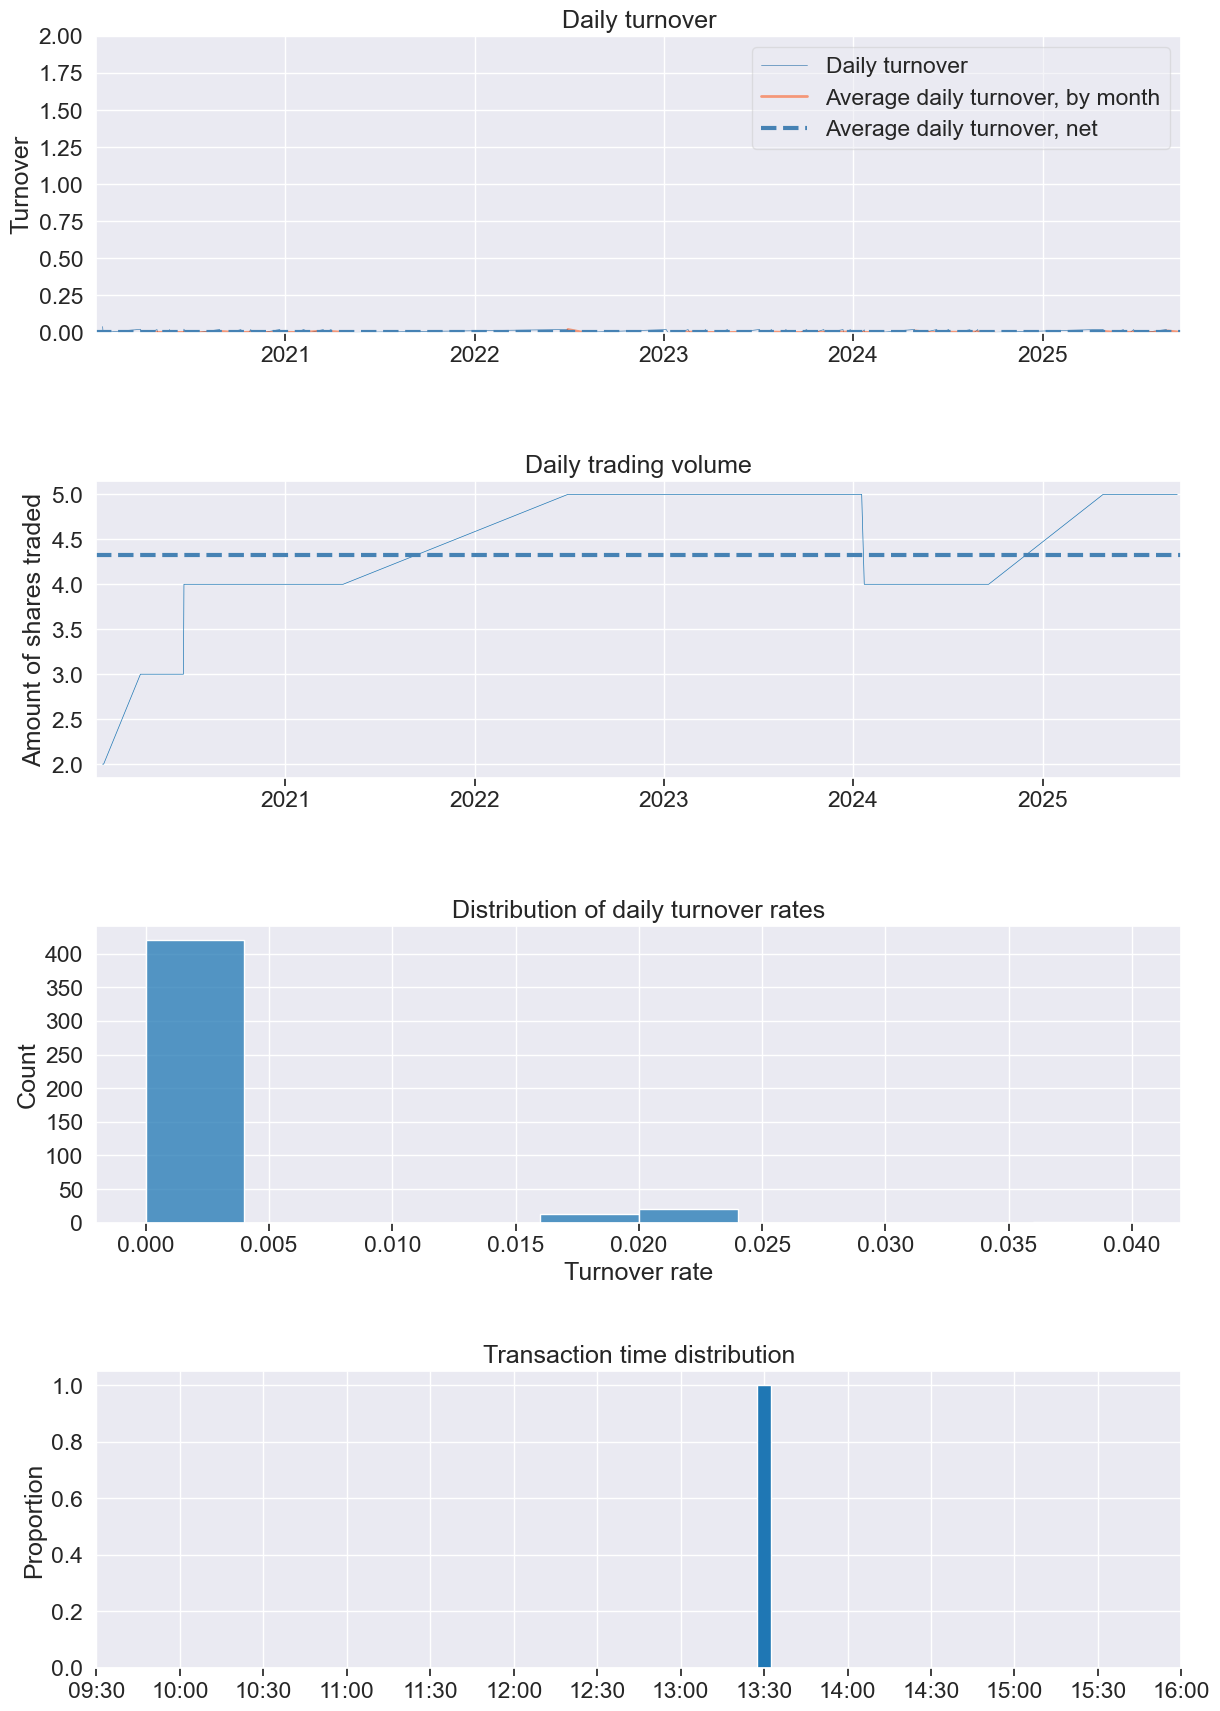

In [2]:
#%% Strategy 1.3

# 目前最讚的版本的修改版 + 濾網天數限制
'''========================================================================================='''

# 策略參數
#---------------------------------------------------------------------------------------------
'''
未觸發濾網時 MA3 & MA10 黃金交叉 => 買進(全倉，槓桿 1.8倍)，濾網開啟 or 死亡交叉 or 觸發停損條件 or 超過持有天數 => 平倉
'''
# 均線參數
SHORT_MA = 3
LONG_MA = 10

# 停損參數
MAX_HOLD_DAYS = 200
STOPLOSS_1D = 5
STOPLOSS_5D = 10
STOPLOSS_10D = 15

# 濾網參數

FILLTER_ON_ACCDAY = 2
FILLTER_OF_ACCDAY = 3

FILLTER_ON_TRIGGER = -5
FILLTER_OF_TRIGGER = 5
FILLTER_AUTO_OFF_DAYS = 200  # 濾網開啟後自動關閉天數

# 槓桿參數
LEVERAGE = 1.8
MAX_LEVERAGE = LEVERAGE + 0.05

# 其他
MTX_CONTRACT_MULTIPLIER = 50    # 小台乘數（請依你行情系統設定）
CAPITAL_BASE = 1e6
START_DT = pd.Timestamp('2020-01-02', tz='utc')
END_DT   = pd.Timestamp('2025-09-26', tz='utc')

print(f'最大槓桿：{MAX_LEVERAGE} 倍')
print("[Trading log---------------]: ----------------------------- | signal ----- |action|Original posi| Note")
#---------------------------------------------------------------------------------------------

def initialize(context):
    set_benchmark(symbol('IR0001'))

    set_commission(
        futures=PerContract(
            cost          = {'MTX': 15},
            exchange_fee  = 0
        )
    )

    set_slippage(
        futures=FixedSlippage(spread=1.0))

    # set_max_leverage(MAX_LEVERAGE)

    context.asset = continuous_future('MTX', offset=0, roll='calendar', adjustment='add')
    context.universe = [context.asset]
    context.in_position = False
    context.hold_days = 0
    context.wait_after_stoploss = 0
    context.filter_triggered = 0  # 添加濾網狀態變數
    context.filter_days = 0  # 濾網開啟天數計數器

    schedule_function(ma_strategy, date_rules.every_day(), time_rules.market_close())

def ma_strategy(context, data):
    # 獲取足夠的歷史資料
    hist = data.history(context.asset, ['close'], bar_count=max(LONG_MA+2, 15), frequency='1d')
    close = hist['close']
    
    # 獲取基準指標歷史資料
    benchmark_hist = data.history(symbol('IR0001'), ['close'], bar_count=7, frequency='1d')
    benchmark_close = benchmark_hist['close']
    
    # 計算策略累計報酬
    return_1d  = (close.iloc[-1] - close.iloc[-2]) / close.iloc[-2] * 100
    return_5d  = (close.iloc[-1] - close.iloc[-6]) / close.iloc[-6] * 100
    return_10d = (close.iloc[-1] - close.iloc[-11]) / close.iloc[-11] * 100

    # 計算指數累計報酬
    benchmark_return_on = (benchmark_close.iloc[-1] - benchmark_close.iloc[-(FILLTER_ON_ACCDAY+1)]) / benchmark_close.iloc[-(FILLTER_ON_ACCDAY+1)] * 100
    benchmark_return_of = (benchmark_close.iloc[-1] - benchmark_close.iloc[-(FILLTER_OF_ACCDAY+1)]) / benchmark_close.iloc[-(FILLTER_OF_ACCDAY+1)] * 100

    # 計算均線
    short_ma = close.rolling(window=SHORT_MA).mean()
    long_ma = close.rolling(window=LONG_MA).mean()

    # 判斷是否有持倉
    contract = data.current(context.asset, 'contract')
    open_positions = context.portfolio.positions
    in_position = contract in open_positions and open_positions[contract].amount != 0
    value = context.portfolio.portfolio_value

    # 計算黃金交叉訊號
    # golden_cross = (short_ma.iloc[-2] < long_ma.iloc[-2]) and (short_ma.iloc[-1] > long_ma.iloc[-1])
    golden_cross = (short_ma.iloc[-2] < long_ma.iloc[-2]) and (short_ma.iloc[-1] > long_ma.iloc[-1] * 1.0001)

    # 計算死亡交叉訊號
    death_cross  = (short_ma.iloc[-2] > long_ma.iloc[-2]) and (short_ma.iloc[-1] < long_ma.iloc[-1])

    # 計算停損訊號
    stop_loss_flag = (return_1d < -STOPLOSS_1D) or (return_5d < -STOPLOSS_5D) or (return_10d < -STOPLOSS_10D)

    # 計算濾網訊號

    if context.filter_triggered == 0:
        if benchmark_return_on <= FILLTER_ON_TRIGGER:
            context.filter_triggered = 1
            context.filter_days = 0  # 重置濾網天數計數器
            #----------------------------------|--------------|
            log.info(f'{get_datetime().date()} | Filter ON    | Benchmark {FILLTER_ON_ACCDAY}d return: {benchmark_return_on:.2f}%')

    else:  # context.filter_triggered == 1
        context.filter_days += 1  # 濾網天數計數器增加
        
        # 檢查濾網自動關閉條件：天數達到上限
        if context.filter_days >= FILLTER_AUTO_OFF_DAYS:
            context.filter_triggered = 0
            context.filter_days = 0
            #----------------------------------|--------------|
            log.info(f'{get_datetime().date()} | Filter OFF   | Auto off after {FILLTER_AUTO_OFF_DAYS} days')
        
        # 檢查濾網關閉條件：市場反彈
        elif benchmark_return_of >= FILLTER_OF_TRIGGER:
            context.filter_triggered = 0
            context.filter_days = 0
            #----------------------------------|--------------|
            log.info(f'{get_datetime().date()} | Filter OFF   | Benchmark {FILLTER_OF_ACCDAY}d return: {benchmark_return_of:.2f}%')

    # 計算進出場訊號

    # 濾網未觸發時，依策略進出場
    if context.filter_triggered == 0:

        # 有部位 => 判斷出場時機
        if in_position:
            context.hold_days += 1

            # 移動停損
            if stop_loss_flag:
                order_value(contract, 0)
                #----------------------------------|--------------|
                log.info(f'{get_datetime().date()} | STOP_LOSS    | sell | position: {open_positions[contract].amount if contract in open_positions else 0} | Hold Days: {context.hold_days}')
                context.hold_days = 0
                context.wait_after_stoploss = 5
            
            # 死亡交叉
            elif death_cross:
                order_value(contract, 0)
                #----------------------------------|--------------|
                log.info(f'{get_datetime().date()} | Death Cross  | sell | position: {open_positions[contract].amount if contract in open_positions else 0} | Hold Days: {context.hold_days}')
                context.hold_days = 0    
            
            # 超過持有天數限制
            elif context.hold_days >= MAX_HOLD_DAYS:
                order_value(contract, 0)
                #----------------------------------|--------------|
                log.info(f'{get_datetime().date()} | Max Hold     | sell | position: {open_positions[contract].amount if contract in open_positions else 0} | Hold Days: {context.hold_days}')
                context.hold_days = 0

        # 無部位 => 判斷進場時機
        else:
            context.hold_days = 0
            if context.wait_after_stoploss > 0:
                context.wait_after_stoploss -= 1
            elif golden_cross:
                order_value(contract, value * LEVERAGE)
                #----------------------------------|--------------|
                log.info(f'{get_datetime().date()} | Golden Cross | buy  | position: {open_positions[contract].amount if contract in open_positions else 0} | Amount: {value * LEVERAGE}')
                context.hold_days = 0
    
    # 濾網觸發時，無條件直接平倉
    else: # context.filter_triggered == 1
        
        if in_position:
            context.hold_days += 1
            order_value(contract, 0)
            #----------------------------------|--------------|
            log.info(f'{get_datetime().date()} | Filter Close | sell | position: {open_positions[contract].amount if contract in open_positions else 0} | Hold Days: {context.hold_days} | Filter Days: {context.filter_days}')
            context.hold_days = 0
            context.wait_after_stoploss = 5

    record(close=data.current(context.asset, 'price'))
    record(position=open_positions[contract].amount if contract in open_positions else 0)
    record(filter_status=context.filter_triggered)  # 記錄濾網狀態

def analyze(context=None, results=None):
    close = results['close']
    ma3 = close.rolling(window=3).mean()
    ma10 = close.rolling(window=10).mean()
    position = results['position']  
    filter_status = results.get('filter_status', pd.Series(0, index=results.index))  # 濾網狀態

    fig, (ax1, ax2, ax3) = plt.subplots(
        3, 1, 
        figsize=(16, 9), 
        sharex=True,
        gridspec_kw={'height_ratios': [4, 2, 2]}
        )

    # 上方：策略與基準績效
    results.algorithm_period_return.plot(label='Strategy', ax=ax1)
    results.benchmark_period_return.plot(label='Benchmark', ax=ax1)
    ax1.set_title('MTX 3MA/10MA Crossover Strategy with Filter (Dynamic Contracts)')
    ax1.legend(loc="upper left")
    ax1.grid(True)

    # 中間：收盤價、均線與持倉區塊
    # ax2.plot(close.index, close, label='MTX Close')
    ma_diff = ma3 - ma10

    ax2.set_title('MTX Close, MA3, MA10 with Position Highlight')
    ax2.bar(ma_diff.index, ma_diff, width=0.8, alpha=0.7, label='MA3-MA10', 
            color=['black' if x > 0 else 'black' for x in ma_diff])
    ax2.axhline(y=0, color='black', linewidth=2, linestyle='-')
    ax2.set_ylabel('MA3 - MA10')
    ax2.legend(loc="upper left")
    ax2.grid(True)
    # ax2.plot(ma3.index, ma3, label='MA3')
    # ax2.plot(ma10.index, ma10, label='MA10')

    # 下方：濾網狀態
    ax3.plot(filter_status.index, filter_status, label='Filter Status', color='red', linewidth=2)
    ax3.fill_between(filter_status.index, 0, filter_status, alpha=0.3, color='red', 
                     where=(filter_status > 0), label='Filter ON')
    ax3.set_ylim(-0.1, 1.1)
    ax3.set_ylabel('Filter Status')
    ax3.set_title('Filter Status (0=OFF, 1=ON)')
    ax3.legend(loc="upper left")
    ax3.grid(True)

    # 添加持倉區塊到所有圖表
    in_position = (position > 0)
    start = None
    for i in range(len(in_position)):
        if in_position.iloc[i] and start is None:
            start = i
        elif not in_position.iloc[i] and start is not None:
            ax1.axvspan(close.index[start], close.index[i-1], color='orange', alpha=0.3)
            ax2.axvspan(close.index[start], close.index[i-1], color='orange', alpha=0.3)
            ax3.axvspan(close.index[start], close.index[i-1], color='orange', alpha=0.3)
            start = None
    if start is not None:
        ax1.axvspan(close.index[start], close.index[-1], color='orange', alpha=0.3)
        ax2.axvspan(close.index[start], close.index[-1], color='orange', alpha=0.3)
        ax3.axvspan(close.index[start], close.index[-1], color='orange', alpha=0.3)

    plt.tight_layout()
    plt.show()

results = run_algorithm(
    start            = START_DT,
    end              = END_DT,
    initialize       = initialize,
    capital_base     = CAPITAL_BASE,
    analyze          = analyze,
    data_frequency   = 'daily',
    bundle           = 'tquant_future',
    trading_calendar = get_calendar('TEJ'),
)

#%% pyfolio
'''========================================================================================='''

plt.rcParams['font.sans-serif'] = ['Arial', 'Noto Sans CJK TC', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

try:
    returns, positions, transactions = extract_rets_pos_txn_from_zipline(results)
    # print('returns:', returns.head())
    # print('positions:', positions.head())
    # print('transactions:', transactions.head())

except Exception as e:
    print('extract_rets_pos_txn_from_zipline error:', e)
    returns = results.get('algorithm_period_return', None)
    positions = None
    transactions = None
    if returns is not None:
        print('returns (fallback):', returns.head())

benchmark_rets = getattr(results, 'benchmark_return', None)

if benchmark_rets is None and hasattr(results, 'benchmark_period_return'):
    benchmark_rets = results.benchmark_period_return
    
if benchmark_rets is not None:
    print('benchmark_rets:', benchmark_rets.head())
else:
    print('No benchmark returns found!')
    
if returns is not None:
    pf.tears.create_full_tear_sheet(
        returns=returns,
        positions=positions,
        transactions=transactions,
        benchmark_rets=benchmark_rets
    )
else:
    print('No returns data for pyfolio.')

#%% Summary
'''========================================================================================='''

summary_strategy = pf.timeseries.perf_stats(returns, factor_returns=benchmark_rets)
summary_benchmark = pf.timeseries.perf_stats(benchmark_rets)
summary = pd.concat([summary_strategy, summary_benchmark], axis=1)
summary.columns = ['Strategy', 'Benchmark']
summary = summary.round(4)

summary